In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
from indicators import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [216]:
def pull_prices(symbol, sd, ed):
    """
        helper method for reading in and preprocessing the prices data

        inputs:
            symbol: string representing the stock symbol for trading
            sd:     string representing the date to start trading
            ed:     string representing the date to stop trading

        output:
            prices: dataframe containing the preprocessed daily price data
                    for the given stock
    """
    #reading in the stock data using util.py and removing nulls
    df = yf.download(symbol, start=sd, end=ed,
                     group_by="ticker", auto_adjust=True)
    prices = df.filter(items=['Close'],axis=1)
    prices.columns = [symbol]
    prices.fillna(method='ffill', inplace=True) #forward-filling missing prices
    prices.fillna(method='bfill', inplace=True) #back-filling missing prices
    return prices

In [189]:
def generate_indicators(prices, n):
    """
        helper method for generating features dataframe containing the
        training indicators

        inputs:
            prices:        dataframe containing the daily prices of a stock
            n:             integer representing the window for the stock price 
                           indicators

        output:
            indicators_df: dataframe containing the Price/SMA Ratio,
                           Bollinger Bands, and Volatility of the daily
                           stock prices
    """
    #creating the indicator dfs
    price_sma_df = price_sma_ratio(prices, n)
    bb_df = bollinger_bands(prices, n)
    vol_df = volatility(prices, n)

    #creating features dataframe for training the regressor
    indicators_df = price_sma_df.join(bb_df,rsuffix="1").join(vol_df,rsuffix="2")
    indicators_df.columns = ["Price/SMA", "Bollinger Bands", "Volatility"]
    
    #adding column for the previous days closing prices
    indicators_df["Previous Price"] = prices.shift(2).values
    
    return indicators_df

In [190]:
def test_code(learner, orders_sl_df, sd, ed, symbol, sv, plot_title, plot_indicators_bool = False):
    #reading in SPY prices over the in-sample date range
    prices = learner.preprocess_data(symbol, sd, ed)
    #test trades using marketsimcode
    portvals_sl = compute_portvals(orders_sl_df, start_val = sv, commission=0.0, impact=0.005)

    prices['Strategy Learner'] = portvals_sl
    prices['Predicted Price'] = learner.prices_pred
    plot_winnings(prices, plot_title, ["Strategy Learner",
                  "Prices"], [], [])
    adr,sddr,cr = port_stats(portvals_sl)

    #if plot_indicators_bool == True, then plotting the indicator graphs
    if plot_indicators_bool:
        price_sma_plot(prices, n = 10)
        bb_plot(prices, n = 10)
        volatility_plot(prices, n = 10)

    # Print statistics
    print(f"Start Date: {sd}")
    print(f"End Date: {ed}")
    print(f"Symbol: {symbol}")
    
    print(f"SL: Std Dev of Daily Returns: %.5f"%sddr)
    print(f"SL: Average Daily Return: %.5f"%adr)
    print(f"SL: Cumulative Return: %.5f"%cr)

## In-Sample Period

In [229]:
#storing the symbol to trade, starting and ending dates for trading
symbol = 'AAPL'
sd = '2012-01-01'
ed = '2013-12-31'

#reading in adjusted closing prices
prices = pull_prices(symbol, sd, ed)

#normalizing the prices
ss = StandardScaler()
prices_norm = pd.DataFrame(ss.fit_transform(prices),index=prices.index, columns=[symbol])

prices_norm.head()

Exception in thread Thread-36:
Traceback (most recent call last):
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py", line 453, in wrap_socket
    cnx.do_handshake()
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\OpenSSL\SSL.py", line 1915, in do_handshake
    self._raise_ssl_error(self._ssl, result)
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\OpenSSL\SSL.py", line 1647, in _raise_ssl_error
    _raise_current_error()
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\OpenSSL\_util.py", line 54, in exception_from_error_queue
    raise exception_type(errors)
OpenSSL.SSL.Error: [('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-pac

KeyboardInterrupt: 

In [218]:
#generating the indicators from the price data
n = 10
indicators = generate_indicators(prices_norm, n)
#removing the first n rows of the indicators df to remove nulls 
indicators = indicators.iloc[n:,:]
#removing the first n rows of the prices df to match the indicators df
prices_norm = prices_norm.iloc[n:,:]
indicators.head()

,Price/SMA,Bollinger Bands,Volatility,Previous Price
Date,,,,
2012-01-18,-0.008674,1.345069,-0.287062,-1.469857
2012-01-19,-0.003027,0.999659,-0.286849,-1.404742
2012-01-20,0.013087,-0.920177,-0.285619,-1.346019
2012-01-23,-0.000839,0.763345,-0.285141,-1.364129
2012-01-24,0.013655,-0.899240,-0.284354,-1.463333


In [219]:
prices_norm.head()

,AAPL
Date,
2012-01-18,-1.346019
2012-01-19,-1.364129
2012-01-20,-1.463333
2012-01-23,-1.368656
2012-01-24,-1.461868


In [220]:
#using ridge regression to predict the stock prices
# model = make_pipeline(PolynomialFeatures(5),Ridge(alpha=0.8, random_state=0))
model = Ridge(alpha=0.001, random_state=0)
model.fit(indicators, prices_norm)
prices_pred = model.predict(indicators)

#scoring model
print("R-Squared of Model: %0.5f"%model.score(indicators, prices_norm))

R-Squared of Model: 0.98340


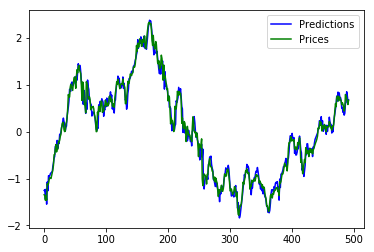

In [221]:
plt.plot(prices_pred, color='b', label='Predictions')
plt.plot(prices_norm.values, color='g', label='Prices')
plt.legend()
plt.show()

## Out-of-Sample Period 

In [235]:
#storing the symbol to trade, starting and ending dates for trading
symbol = 'AAPL'
sd = '2018-01-01'
ed = '2019-11-27'

#reading in adjusted closing prices
prices = pull_prices(symbol, sd, ed)

#normalizing the prices
ss = StandardScaler()
prices_norm = pd.DataFrame(ss.fit_transform(prices),index=prices.index, columns=[symbol])

#generating the indicators from the price data
n = 10
indicators = generate_indicators(prices_norm, n)
#removing the first n rows of the indicators df to remove nulls 
indicators = indicators.iloc[n:,:]
#removing the first n rows of the prices df to match the indicators df
prices_norm = prices_norm.iloc[n:,:]

prices_norm["Predicted Price"] = model.predict(indicators)
prices_norm.head()

Exception in thread Thread-37:
Traceback (most recent call last):
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py", line 453, in wrap_socket
    cnx.do_handshake()
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\OpenSSL\SSL.py", line 1915, in do_handshake
    self._raise_ssl_error(self._ssl, result)
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\OpenSSL\SSL.py", line 1647, in _raise_ssl_error
    _raise_current_error()
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-packages\OpenSSL\_util.py", line 54, in exception_from_error_queue
    raise exception_type(errors)
OpenSSL.SSL.Error: [('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ord-ryanmi\AppData\Local\Continuum\anaconda3\lib\site-pac

KeyboardInterrupt: 


R-Squared of Model: 0.98499


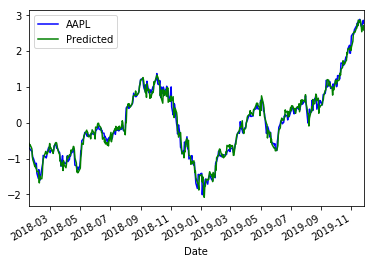

In [234]:
#scoring model
print()
print("R-Squared of Model: %0.5f"%model.score(indicators, prices_norm.iloc[:,0]))

prices_norm.plot(color=['b','g'])
# plt.plot(x=prices_norm.index, y=prices_pred, color='b', label='Predictions')
# plt.plot(x=prices_norm.index, y=prices_norm.values, color='g', label='Prices')
plt.legend()
plt.show()